In [1]:
import numpy as np
import random
import pylab
from agent import *
from maze import *
from neural_network import *
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Number of training cycles
episodes = 15000

# Hrr parameters
hrr_length = 8192
normalized = True

# How many steps to take before quiting
steps_till_quit = 50

# Maze parameters
size_of_maze = 11
non_obs_task_switch_rate = 50
num_non_obs_tasks = 1
num_obs_tasks = 2
# goals = [[0,2,1], [1,0,2],[2,1,0]]
# signals = ["red", "green", "blue"]
goals = [2, 4, 8]
signals = ["red", "blue", "green"]

# random goal setting
# goals = np.stack([np.random.choice(range(size_of_maze), num_non_obs_tasks, replace=False) for _ in range(num_obs_tasks)])

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.5
alpha = 0.05

# Reward for temporal difference learning
reward_bad = 0
reward_good = 1

# Expolration rate
e_soft = 0.03

# Threshold for non observable task switching
threshold = -0.2

# Print frequency
p_freq = 100

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.1

# atr = np.random.randint(0, num_non_obs_tasks + 1)
atr = 0
wm = "I"

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

if_p = False

In [3]:
agent = agent()
maze = maze(size_of_maze, non_obs_task_switch_rate, num_non_obs_tasks, num_obs_tasks, goals)
nn = NeuralNetwork(input_size, output_size, bias, discount, alpha, reward_good, reward_bad)
ltm = LTM("hrrs_" + str(hrr_length), hrr_length, normalized)

In [4]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]


In [5]:
def move_policy(goal, moves, wms, signals, atr, rand_on):
    
    val = -9999
    temp = -9999
    
    if if_p:
        print(moves, wms, signals, atr[0])
        
    for move in moves:
        for wm in list(dict.fromkeys(wms + ["I"])):
            for signal in list(dict.fromkeys(signals + ["I"])):
                if move == goal:
                    encode_str = build_hrr_string(wm, signal, str(move) + "*rewardTkn", atr[0])
                else:
                    encode_str = build_hrr_string(wm, signal, move, atr[0])
                temp = np.dot(weights, ltm.encode(encode_str)) + bias
                if if_p:
                    if signal != "I":
                        print("Move:", move, "WM:", wm, "Signal", signal + "In", "ATR:", atr[0], "Value:", temp)
                    else:
                        print("Move:", move, "WM:", wm, "Signal", signal, "ATR:", atr[0], "Value:", temp)
                if temp > val:
                    val = temp
                    s_move = move
                    if signal != "I":
                        s_wm = signal + "In"
                    elif wm != "I":
                        s_wm = wm
                    else:
                        s_wm = "I"
    
    # Random move
    if((np.random.random_sample() < e_soft) and (rand_on == 1)):
        if if_p:
            print("Random move")
        return np.random.choice(moves), random.choice(wms), random.choice(atr)                

                    
    s_atr = atr[0]
    return s_move, s_wm, s_atr

def context_policy(atr):
    return (atr + 1)%num_non_obs_tasks

def build_hrr_string(wm, signal, state, atr):
    if wm == "I" and signal == "I":
        return "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif wm == "I":
        return "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif signal == "I":
        return "WM:" + str(wm) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    else:
        return "WM:" + str(wm) + "*" + "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)

In [6]:
for x in range(episodes):
    
    if x > episodes - 2:
        if_p = True
    
    # Starting state
    current_state = random.randint(0, size_of_maze - 1)
    
    # Signal for the maze run
    current_signal = np.random.choice(signals)
    
    # Maze progresses
    #non_obs, goal = maze.step_maze(signals.index(signal))
    non_obs = 0
    current_atr = 0
    
    goal = goals[signals.index(current_signal)]
        
    if if_p:
        print(current_signal, goal)
    
    # Reset trace
    eligibility *= 0.0
    
    current_wm = "I"
    
    y = 0
    
    if if_p:
        print("Expected: Goal: " + str(goal) + " Signal: " + str(current_signal) + " Non_Observable: " + str(non_obs))
    
    for y in range(steps_till_quit):
        
        # Goal reached
        if (current_state == goal):
            # Get temporal difference error and update weights of neural network
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)
            goal_hrr = ltm.encode(encode_str)
            goal_value = np.dot(weights, goal_hrr) + bias            
            
            if if_p:
                print("In Goal: State Value: " + str(goal_value) + " WM: " + str(current_wm) + " Atr: " + str(current_atr) + "\n\n\n\n\n")
            
            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * error * eligibility))
            
            break
        
        # Store info about previous state      
        previous_wm = current_wm
        previous_signal = current_signal
        previous_state = current_state
        previous_atr = current_atr
        
        if if_p:
            print("Previous WM:", previous_wm, "Signal:", previous_signal, "State", previous_state, "ATR:", previous_atr)
        
        encode_str = build_hrr_string(previous_wm, previous_signal, previous_state, previous_atr)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = np.dot(weights, previous_state_hrr) + bias
              
        if if_p:
            print("Started with: State: " + str(previous_state) + " State Value: " + str(previous_value) + " WM: " + str(previous_wm) + " Atr: " + str(previous_atr))
    
        current_signal = "I"
        left, right = agent.get_moves(previous_state, size_of_maze)
        if previous_signal != "I":
            previous_signal += "In"
        move, wm, atr = move_policy(goal, [left, right], [previous_wm, previous_signal], [current_signal], [previous_atr], 1)
        
        
        # Make the move
        current = move
        
        current_wm = wm
        current_state = current
        current_atr = atr
        
        if if_p:
            print("Current WM:", current_wm, "Signal:", current_signal, "State", current_state, "ATR:", current_atr)
        
        if current_state == goal:
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)
        else:
            encode_str = build_hrr_string(current_wm, current_signal, current_state, current_atr)

        current_state_hrr = ltm.encode(encode_str)
        current_value = np.dot(weights, current_state_hrr) + bias
        
        if if_p:
            print("Moved: State: " + str(current_state) + " State Value: " + str(current_value) + " WM: " + str(current_wm) + " Atr: " + str(current_atr))
        
        # Weight update for goal not found
        error = (reward_bad + discount * current_value) - previous_value
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        if error < threshold and num_non_obs_tasks > 1:
                atr = context_policy(atr)
                eligibility = eligibility * 0.0
                if if_p:
                    print("Atr after policy: " + str(atr))
                
        weights = np.add(weights, (alpha * error * eligibility))
        
        if if_p:
            print()

    if if_p and y == steps_till_quit - 1:
        print("Fail\n")
        
    if if_p:
        print("\n\n")
        input("Press Enter to continue...")
      
    if((x+1)%p_freq == 0):
        print("Episode" , x+1, "done")
    #if y >= steps_till_quit:
        #print("Failed and broke out\n\n\n\n\n")

Episode 100 done
Episode 200 done
Episode 300 done
Episode 400 done
Episode 500 done
Episode 600 done
Episode 700 done
Episode 800 done
Episode 900 done
Episode 1000 done
Episode 1100 done
Episode 1200 done
Episode 1300 done
Episode 1400 done
Episode 1500 done
Episode 1600 done
Episode 1700 done
Episode 1800 done
Episode 1900 done
Episode 2000 done
Episode 2100 done
Episode 2200 done
Episode 2300 done
Episode 2400 done
Episode 2500 done
Episode 2600 done
Episode 2700 done
Episode 2800 done
Episode 2900 done
Episode 3000 done
Episode 3100 done
Episode 3200 done
Episode 3300 done
Episode 3400 done
Episode 3500 done
Episode 3600 done
Episode 3700 done
Episode 3800 done
Episode 3900 done
Episode 4000 done
Episode 4100 done
Episode 4200 done
Episode 4300 done
Episode 4400 done
Episode 4500 done
Episode 4600 done
Episode 4700 done
Episode 4800 done
Episode 4900 done
Episode 5000 done
Episode 5100 done
Episode 5200 done
Episode 5300 done
Episode 5400 done
Episode 5500 done
Episode 5600 done
E

Press Enter to continue... 


Episode 15000 done


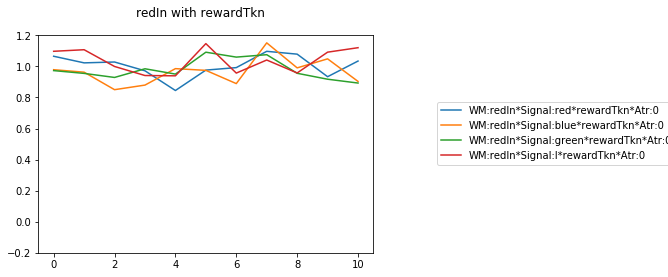

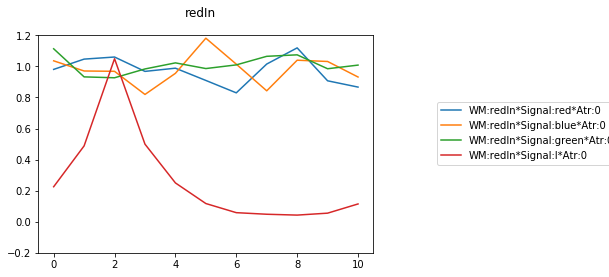

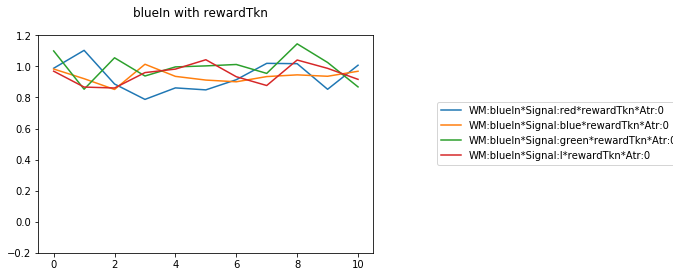

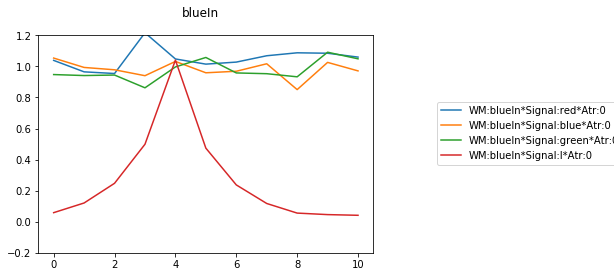

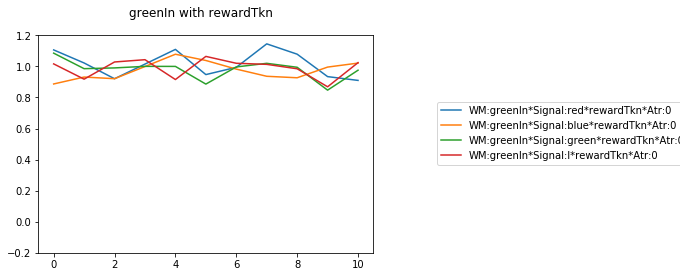

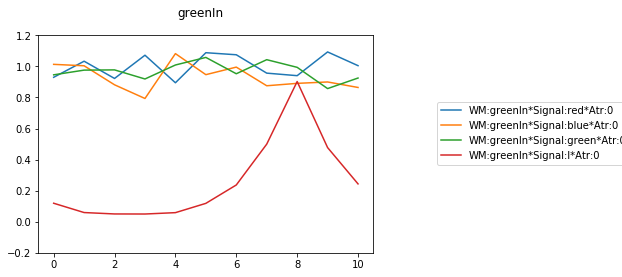

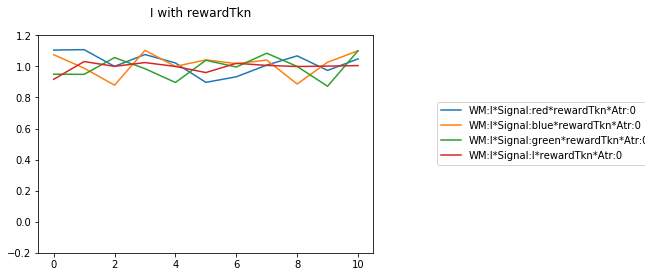

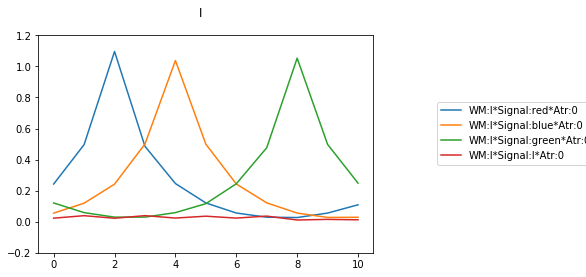

In [7]:
atr = 0
x = 0
for wm in [signal + "In" for signal in signals] + ["I"]:
    x += 1
    y = x
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    y = plt.figure(x)
    for signal in signals + ["I"]:
        lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn*Atr:" + str(atr)
        for state in range(size_of_maze):
            encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn", atr)
            value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
        plt.plot(position, value, label=lab)
    plt.ylim((-0.2, 1.2))
    y.suptitle(wm + " with rewardTkn")
    y.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    x += 1
    y = x
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    y = plt.figure(x)
    for signal in signals + ["I"]:
        lab = "WM:" + wm + "*Signal:" + signal + "*Atr:" + str(atr)
        for state in range(size_of_maze):
            encode_str = build_hrr_string(wm, signal, str(state), atr)
            value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
        plt.plot(position, value, label=lab)
    plt.ylim((-0.2, 1.2))
    y.suptitle(wm)
    y.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
ltm.print()

Signal:red*State:4*rewardTkn [-0.00838921  0.00280738  0.00639213 ...  0.00770611 -0.01544293
 -0.00561518]
Atr:0*State:5*WM:greenIn [ 0.01682801  0.0003042  -0.00417123 ...  0.01519039  0.00030196
  0.0048586 ]
Signal:green*State:1*WM:greenIn*rewardTkn [-0.00191026 -0.00304484  0.0010365  ... -0.01844036  0.00365421
 -0.00927092]
Signal:red*State:5*WM:blueIn*rewardTkn [ 0.00834652  0.0037877  -0.0001642  ... -0.00370901 -0.00684102
  0.00169964]
Signal:blue*State:1*WM:blueIn [ 0.01450984 -0.01242227 -0.01703145 ...  0.00137253  0.00912926
  0.00984592]
State:0*WM:redIn*rewardTkn [-0.00676277 -0.00531682 -0.01336766 ...  0.00470792 -0.0021555
  0.01180583]
Signal:blue*WM:greenIn [ 0.01103493 -0.01871967  0.00638933 ... -0.01727457 -0.00164094
 -0.010431  ]
Signal:red*State:10*WM:blueIn [ 0.01331815  0.00318395  0.01291454 ...  0.00738697 -0.0003138
 -0.00759864]
Atr:0*Signal:green*State:5*WM:redIn [-0.01597816  0.00767574  0.00671498 ... -0.00399359  0.00878296
  0.01646785]
Signal:blu

In [9]:
ltm.clean()
del ltm, agent, maze, nn